In [1]:
#Importing the required modules and general setup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import iqr
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleAdiabatic
from galpy.df import quasiisothermaldf
from galpy.util.bovy_coords import *
import sys
sys.path.append('..')

#Importing qdf load data
samples_qdf = np.load('../mock_data/qdf/data/sampleV_at_(0.0,0.0,0.0)_epsilon=0.5_rect.npy')

#Setting up action angle and qdf instances
aA = actionAngleAdiabatic(pot=MWPotential2014,c=True)
qdf = quasiisothermaldf(1./3.,0.2,0.1,1.,1.,pot=MWPotential2014,aA=aA,cutcounter=True)

#convert cylindrical to rectangular
R, phi, z = rect_to_cyl(samples_qdf[:,0], samples_qdf[:,1], samples_qdf[:,2])
vR, vT, vz = rect_to_cyl_vec(samples_qdf[:,3], samples_qdf[:,4], samples_qdf[:,5], samples_qdf[:,0], samples_qdf[:,1], samples_qdf[:,2])
samples_qdf = np.stack((R, phi, z, vR, vT, vz), axis=1)


print('#stars', len(samples_qdf))
print('min/max/mean (R)', min(samples_qdf[:,0]), max(samples_qdf[:,0]), np.mean(samples_qdf[:,0]))
print('min/max/mean (phi)', min(samples_qdf[:,1]), max(samples_qdf[:,1]), np.mean(samples_qdf[:,1]))
print('min/max/mean (z)', min(samples_qdf[:,2]), max(samples_qdf[:,2]), np.mean(samples_qdf[:,2]))
print('min/max/mean (vR)', min(samples_qdf[:,3]), max(samples_qdf[:,3]), np.mean(samples_qdf[:,3]))
print('min/max/mean (vT)', min(samples_qdf[:,4]), max(samples_qdf[:,4]), np.mean(samples_qdf[:,4]))
print('min/max/mean (vz)', min(samples_qdf[:,5]), max(samples_qdf[:,5]), np.mean(samples_qdf[:,5]))
print(np.std(samples_qdf[:,0]), np.std(samples_qdf[:,1]), np.std(samples_qdf[:,2]), np.std(samples_qdf[:,3]), np.std(samples_qdf[:,4]), np.std(samples_qdf[:,5]))

#stars 1699708
min/max/mean (R) 7.80091199779 8.79962027735 8.29194098976
min/max/mean (phi) 3.08134693839 3.20183526017 3.14130030289
min/max/mean (z) -0.472240992289 0.525186432321 0.0205541620714
min/max/mean (vR) -226.541732449 236.497052579 0.00739381590152
min/max/mean (vT) 18.0377131063 300.644001151 200.9257125
min/max/mean (vz) -78.6318475051 79.4952977672 -0.00151810605736
0.19569240168 0.024711492153 0.16310598222 44.5400796638 32.3019489683 18.9869492162


In [2]:
#Defining a KDE function to quickly compute probabilities for the data set
def generate_KDE(inputs, ker):
    """
    NAME:
        generate_KDE
    
    PURPOSE:
        Given an NxM matrix for inputs and one of six avaliable ker strings, 
        outputs a function `input_DKE` that treats the density estimate as a 
        black box function that can be sampled.
    
    INPUT:
        inputs (ndarray) = An NxM matrix where N is the number of data 
                           points and M is the number of parameters.
        ker (string) = One of the 6 avaliable kernel types (gaussian, 
                       tophat, epanechnikov, exponential, linear, cosine).
    
    OUTPUT:
        input_KDE (function) = A blackbox function for the density estimate
                               used for sampling data.
                               
    HISTORY:
        2018-06-25 - Updated - Ayush Pandhi
    """
    #Print statements to check changes
    print('Inputs before scaling:')
    print(inputs)
    print('------------------------------------------------')
    
    #Scaling velocities with z-score
    inputs_std = np.nanstd(inputs, axis=0)
    i1, i2, i3, i4, i5, i6 = np.mean(inputs, axis=0)
    inputs_mean = np.hstack((i1, i2, i3, i4, i5, i6))
    inputs = (inputs - inputs_mean)/inputs_std
    
    #Print statements to check changes
    print('Inputs after scaling:')
    print(inputs)
    print('------------------------------------------------')
    print('Means of oringial inputs:')
    print(inputs_mean)
    print('------------------------------------------------')
    print('Std of original inputs:')
    print(inputs_std)
    print('------------------------------------------------')
    print('Std of scaled inputs:')
    print(np.nanstd(inputs, axis=0))
    print('------------------------------------------------')
    print('Std of 6D inputs:')
    print(np.nanstd(inputs))
    print('------------------------------------------------')
    
    #Optimizing bandwidth in terms of Scott's Rule of Thumb
    shape_string = str(inputs.shape)
    objects, parameters = shape_string.split(', ')
    N_string = objects[1:]
    N = int(N_string)
    bw = 5 * np.nanstd(inputs) * N ** (-1/10.)
    
    #Print statements to check changes
    print('Scotts multivariate bw:')
    print(bw/5.)
    print('------------------------------------------------')
    print('5*Scotts multivariate bw (roughly ideal for smooth plots):')
    print(bw)
    print('------------------------------------------------')
    
    #Fit data points to selected kernel and bandwidth
    kde = KernelDensity(kernel=ker, bandwidth=bw).fit(inputs)  
    
    def input_KDE(samples):
        """
        NAME:
            input_KDE
    
        PURPOSE:
            Given a QxM matrix for samples, evaluates the blackbox density
            estimate function at those points to output a 1xQ array of 
            density values.
    
        INPUT:
            samples (ndarray) = A QxM matrix where Q is the number of points 
                                at which the kde is being evaluated and M is 
                                the number of parameters.
                                
        OUTPUT:
            dens (ndarray) = A 1xQ array of density values for Q data points.
                               
        HISTORY:
            2018-06-25 - Updated - Ayush Pandhi
        """
        #To correct the type of information from other functions into acceptable input
        #samples = np.array([samples])
        
        #Print statements to check changes
        
        #Scaling samples with standard deviation
        samples = (samples - inputs_mean)/inputs_std
        
        #Get the log density for selected samples and apply exponential to get normal probabilities
        log_dens = kde.score_samples(samples)
        dens = np.exp(log_dens)
        
        #Return a 1xQ array of normal probabilities for the selected sample
        return dens
    
    #Return a black box function for sampling
    return input_KDE

In [3]:
#Generate kde for 6D qdf inputs
kde_qdf_epanechnikov = generate_KDE(samples_qdf, 'epanechnikov')

Inputs before scaling:
[[  8.49265590e+00   3.11498000e+00   4.18769788e-01   7.05532691e+00
    2.24733165e+02  -1.11876178e-01]
 [  8.39666847e+00   3.12808855e+00   2.22857453e-01   4.09537519e+01
    1.92442340e+02  -7.37105008e+00]
 [  8.45508853e+00   3.11963922e+00   3.48130325e-01  -1.06576952e+01
    2.26766524e+02  -2.15995690e+01]
 ..., 
 [  8.06021557e+00   3.10684247e+00  -1.74818474e-01   4.34009862e+01
    2.09837551e+02   2.39653267e+01]
 [  8.04260546e+00   3.10404831e+00  -1.89765719e-01   3.72830076e+01
    1.91061840e+02   3.78577201e+00]
 [  8.15632531e+00   3.12114656e+00  -9.24567609e-02  -9.39902557e+00
    1.95854451e+02  -4.00422055e+01]]
------------------------------------------------
Inputs after scaling:
[[ 1.02566533 -1.06510376  2.44145322  0.158238    0.73702835 -0.00581231]
 [ 0.53516377 -0.53464018  1.24031803  0.91931488 -0.26262726 -0.38813671]
 [ 0.83369378 -0.87655914  2.00836388 -0.23944926  0.79997684 -1.13752087]
 ..., 
 [-1.18413092 -1.3944050

In [4]:
#Creating sample points for each parameter changing
N = 1000

#Mean of each parameter as a Nx1 object
mean_R = np.ones((N, 1))*np.mean(samples_qdf[:,0])
mean_phi = np.ones((N, 1))*np.mean(samples_qdf[:,1])
mean_z = np.ones((N, 1))*np.mean(samples_qdf[:,2])
mean_vR = np.ones((N, 1))*np.mean(samples_qdf[:,3])
mean_vT = np.ones((N, 1))*np.mean(samples_qdf[:,4])
mean_vz = np.ones((N, 1))*np.mean(samples_qdf[:,5])

#Generating Nx6 sample points for each varying parameter
#For variable R
R_points = np.linspace(min(samples_qdf[:,0]), max(samples_qdf[:,0]), N)
R_points = R_points.reshape(-1, 1)
sample_R = np.hstack((R_points, mean_phi, mean_z, mean_vR, mean_vT, mean_vz))

#For variable phi
phi_points = np.linspace(min(samples_qdf[:,1]), max(samples_qdf[:,1]), N)
phi_points = phi_points.reshape(-1, 1)
sample_phi = np.hstack((mean_R, phi_points, mean_z, mean_vR, mean_vT, mean_vz))
                 
#For variable z
z_points = np.linspace(min(samples_qdf[:,2]), max(samples_qdf[:,2]), N)
z_points = z_points.reshape(-1, 1)
sample_z = np.hstack((mean_R, mean_phi, z_points, mean_vR, mean_vT, mean_vz))
                 
#For variable vR
vR_points = np.linspace(min(samples_qdf[:,3]), max(samples_qdf[:,3]), N)
vR_points = vR_points.reshape(-1, 1)
sample_vR = np.hstack((mean_R, mean_phi, mean_z, vR_points, mean_vT, mean_vz))

#For variable vT
vT_points = np.linspace(min(samples_qdf[:,4]), max(samples_qdf[:,4]), N)
vT_points = vT_points.reshape(-1, 1)
sample_vT = np.hstack((mean_R, mean_phi, mean_z, mean_vR, vT_points, mean_vz))
                 
#For variable vz
vz_points = np.linspace(min(samples_qdf[:,5]), max(samples_qdf[:,5]), N)
vz_points = vz_points.reshape(-1, 1)
sample_vz = np.hstack((mean_R, mean_phi, mean_z, mean_vR, mean_vT, vz_points))

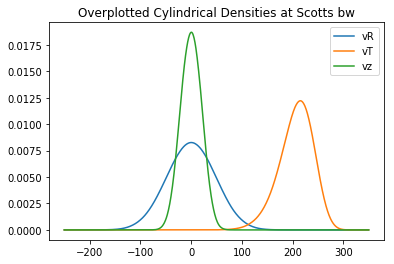

In [21]:
#For variable vR
vR_points = np.linspace(-250, 350, N)
vR_points = vR_points.reshape(-1, 1)
sample_vR = np.hstack((mean_R, mean_phi, mean_z, vR_points, mean_vT, mean_vz))

#For variable vT
vT_points = np.linspace(-250, 350, N)
vT_points = vT_points.reshape(-1, 1)
sample_vT = np.hstack((mean_R, mean_phi, mean_z, mean_vR, vT_points, mean_vz))
                 
#For variable vz
vz_points = np.linspace(-250, 350, N)
vz_points = vz_points.reshape(-1, 1)
sample_vz = np.hstack((mean_R, mean_phi, mean_z, mean_vR, mean_vT, vz_points))

#Overplotting velocities

#Epanechnikov, vR, Scotts
vRplot_epanechnikov = kde_qdf_epanechnikov(sample_vR)
plt.plot(vR_points, vRplot_epanechnikov/np.sum(vRplot_epanechnikov)/(vR_points[1]-vR_points[0]), label='vR')

#Epanechnikov, vT, Scotts
vTplot_epanechnikov = kde_qdf_epanechnikov(sample_vT)
plt.plot(vT_points, vTplot_epanechnikov/np.sum(vTplot_epanechnikov)/(vT_points[1]-vT_points[0]), label='vT')

#Epanechnikov, vz, Scotts
vzplot_epanechnikov = kde_qdf_epanechnikov(sample_vz)
plt.plot(vz_points, vzplot_epanechnikov/np.sum(vzplot_epanechnikov)/(vz_points[1]-vz_points[0]), label='vz')

#Show plot
plt.title('Overplotted Cylindrical Densities at Scotts bw')
plt.legend()
plt.show()

In [6]:
#Integrate over velocities, fix R, phi, z = 8.3, 3.14, 0.
from scipy.integrate import dblquad
import time

#input values for velocities (vR, vT, vz)
v_input = np.linspace(-200, 400, 100)
 
# -----------------
# Integrate over vR
# -----------------

def kde_qdf_cyl_vR(vT, vz, R, phi, z, vR):
    evaluation = kde_qdf_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_vR(kde_qdf_epanechnikov, vR): #bounds of vT = [0, 300], bounds of vz = [-100, 100]
    print ("Evaluating at vR =", vR)
    return dblquad(kde_qdf_cyl_vR, 0, 300, -100, 100, args=([8.3, 3.14, 0., vR]), epsabs=0.001)  # args=(R, phi, z, vR)

vR_output = np.ones([100])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vT from [0, 300] and vz from [-100, 100].")
print("KDE Evaluations along vR from [-200, 400] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vR_output[counter - 1], error = integrate_over_vR(kde_qdf_epanechnikov, v)
    print("Value:", vR_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()
    
# -----------------
# Integrate over vT
# -----------------

def kde_qdf_cyl_vT(vR, vz, R, phi, z, vT):
    evaluation = kde_qdf_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_vT(kde_qdf_epanechnikov, vT): #bounds of vR = [-100, 100], bounds of vz = [-100, 100]
    print ("Evaluating at vT =", vT)
    return dblquad(kde_qdf_cyl_vT, -100, 100, -100, 100, args=([8.3, 3.14, 0., vT]), epsabs=0.01)  # args=(R, phi, z, vR)

vT_output = np.ones([100])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vR from [-100, 100] and vz from [-100, 100].")
print("KDE Evaluations along vT from [-200, 400] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vT_output[counter - 1], error = integrate_over_vT(kde_qdf_epanechnikov, v)
    print("Value:", vT_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()
    
# -----------------
# Integrate over vz
# -----------------

def kde_qdf_cyl_vz(vR, vT, R, phi, z, vz):
    evaluation = kde_qdf_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_vz(kde_qdf_epanechnikov, vz): #bounds of vR = [-100, 100], bounds of vT = [0, 300]
    print ("Evaluating at vz =", vz)
    return dblquad(kde_qdf_cyl_vz, -100, 100, 0, 300, args=([8.3, 3.14, 0., vz]), epsabs=0.001)  # args=(R, phi, z, vR)

vz_output = np.ones([100])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vR from [-100, 100] and vT from [0, 300].")
print("KDE Evaluations along vz from [-200, 400] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vz_output[counter - 1], error = integrate_over_vz(kde_qdf_epanechnikov, v)
    print("Value:", vz_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()




With R, phi, z = 8.3, 3.14, 0., integrating over vT from [0, 300] and vz from [-100, 100].
KDE Evaluations along vR from [-200, 400] over 100 subintervals.

Evaluation: 1
Evaluating at vR = -200.0
Value: 5.00427426197e-05
Time to integrate: 1.1s
Time elapsed: 0.02 min

Evaluation: 2
Evaluating at vR = -193.93939393939394
Value: 0.000101206728637
Time to integrate: 0.37s
Time elapsed: 0.02 min

Evaluation: 3
Evaluating at vR = -187.87878787878788
Value: 0.000177674897819
Time to integrate: 1.25s
Time elapsed: 0.05 min

Evaluation: 4
Evaluating at vR = -181.8181818181818
Value: 0.000284562598673
Time to integrate: 1.21s
Time elapsed: 0.07 min

Evaluation: 5
Evaluating at vR = -175.75757575757575
Value: 0.000396021588893
Time to integrate: 1.28s
Time elapsed: 0.09 min

Evaluation: 6
Evaluating at vR = -169.6969696969697
Value: 0.00053353388294
Time to integrate: 0.42s
Time elapsed: 0.09 min

Evaluation: 7
Evaluating at vR = -163.63636363636363
Value: 0.000694449538341
Time to integrate: 1

Value: 0.000137901233563
Time to integrate: 1.2s
Time elapsed: 2.49 min

Evaluation: 66
Evaluating at vR = 193.93939393939394
Value: 8.48186949427e-05
Time to integrate: 1.11s
Time elapsed: 2.5 min

Evaluation: 67
Evaluating at vR = 200.0
Value: 4.76128924259e-05
Time to integrate: 1.16s
Time elapsed: 2.52 min

Evaluation: 68
Evaluating at vR = 206.06060606060606
Value: 2.08470739807e-05
Time to integrate: 1.18s
Time elapsed: 2.54 min

Evaluation: 69
Evaluating at vR = 212.12121212121212
Value: 5.50380932752e-06
Time to integrate: 1.14s
Time elapsed: 2.56 min

Evaluation: 70
Evaluating at vR = 218.1818181818182
Value: 1.39099427105e-06
Time to integrate: 1.18s
Time elapsed: 2.58 min

Evaluation: 71
Evaluating at vR = 224.24242424242425
Value: 9.54251548575e-14
Time to integrate: 1.12s
Time elapsed: 2.6 min

Evaluation: 72
Evaluating at vR = 230.3030303030303
Value: 6.77477761875e-14
Time to integrate: 1.08s
Time elapsed: 2.62 min

Evaluation: 73
Evaluating at vR = 236.36363636363637
Va

Value: 7.50650568802e-05
Time to integrate: 2.41s
Time elapsed: 0.27 min

Evaluation: 37
Evaluating at vT = 18.181818181818187
Value: 0.000253499662163
Time to integrate: 2.64s
Time elapsed: 0.32 min

Evaluation: 38
Evaluating at vT = 24.24242424242425
Value: 0.000660910136445
Time to integrate: 2.99s
Time elapsed: 0.37 min

Evaluation: 39
Evaluating at vT = 30.30303030303031
Value: 0.00154567241692
Time to integrate: 3.37s
Time elapsed: 0.42 min

Evaluation: 40
Evaluating at vT = 36.363636363636374
Value: 0.00334119459453
Time to integrate: 1.07s
Time elapsed: 0.44 min

Evaluation: 41
Evaluating at vT = 42.424242424242436
Value: 0.00629269475708
Time to integrate: 3.86s
Time elapsed: 0.51 min

Evaluation: 42
Evaluating at vT = 48.48484848484847
Value: 0.0110362754353
Time to integrate: 4.45s
Time elapsed: 0.58 min

Evaluation: 43
Evaluating at vT = 54.54545454545453
Value: 0.0183950940654
Time to integrate: 4.96s
Time elapsed: 0.66 min

Evaluation: 44
Evaluating at vT = 60.60606060606

Value: 0.0
Time to integrate: 0.21s
Time elapsed: 0.01 min

Evaluation: 4
Evaluating at vz = -181.8181818181818
Value: 0.0
Time to integrate: 0.22s
Time elapsed: 0.01 min

Evaluation: 5
Evaluating at vz = -175.75757575757575
Value: 0.0
Time to integrate: 0.22s
Time elapsed: 0.02 min

Evaluation: 6
Evaluating at vz = -169.6969696969697
Value: 0.0
Time to integrate: 0.21s
Time elapsed: 0.02 min

Evaluation: 7
Evaluating at vz = -163.63636363636363
Value: 0.0
Time to integrate: 0.22s
Time elapsed: 0.03 min

Evaluation: 8
Evaluating at vz = -157.57575757575756
Value: 0.0
Time to integrate: 0.22s
Time elapsed: 0.03 min

Evaluation: 9
Evaluating at vz = -151.5151515151515
Value: 0.0
Time to integrate: 0.21s
Time elapsed: 0.03 min

Evaluation: 10
Evaluating at vz = -145.45454545454544
Value: 0.0
Time to integrate: 0.21s
Time elapsed: 0.04 min

Evaluation: 11
Evaluating at vz = -139.39393939393938
Value: 0.0
Time to integrate: 0.23s
Time elapsed: 0.04 min

Evaluation: 12
Evaluating at vz = -13

Value: 0.0
Time to integrate: 0.22s
Time elapsed: 1.39 min

Evaluation: 74
Evaluating at vz = 242.42424242424244
Value: 0.0
Time to integrate: 0.22s
Time elapsed: 1.4 min

Evaluation: 75
Evaluating at vz = 248.4848484848485
Value: 0.0
Time to integrate: 0.22s
Time elapsed: 1.4 min

Evaluation: 76
Evaluating at vz = 254.54545454545456
Value: 0.0
Time to integrate: 0.26s
Time elapsed: 1.4 min

Evaluation: 77
Evaluating at vz = 260.6060606060606
Value: 0.0
Time to integrate: 0.24s
Time elapsed: 1.41 min

Evaluation: 78
Evaluating at vz = 266.6666666666667
Value: 0.0
Time to integrate: 0.22s
Time elapsed: 1.41 min

Evaluation: 79
Evaluating at vz = 272.72727272727275
Value: 0.0
Time to integrate: 0.25s
Time elapsed: 1.42 min

Evaluation: 80
Evaluating at vz = 278.7878787878788
Value: 0.0
Time to integrate: 0.21s
Time elapsed: 1.42 min

Evaluation: 81
Evaluating at vz = 284.8484848484849
Value: 0.0
Time to integrate: 0.22s
Time elapsed: 1.42 min

Evaluation: 82
Evaluating at vz = 290.909090

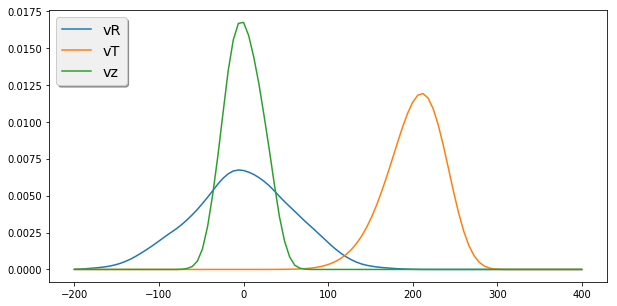

In [17]:
# plot integrated and normalized PDFs
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(v_input, vR_output/np.sum(vR_output)/(v_input[1]-v_input[0]), label='vR') #normalized area to 1
ax.plot(v_input, vT_output/np.sum(vT_output)/(v_input[1]-v_input[0]), label='vT')
ax.plot(v_input, vz_output/np.sum(vz_output)/(v_input[1]-v_input[0]), label='vz')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('#F0F0F0')
plt.show()